In [2]:
import torch
    
import sns_toolbox
from sns_toolbox.connections import NonSpikingPatternConnection
from sns_toolbox.networks import Network
from sns_toolbox.neurons import NonSpikingNeuron
from sns_toolbox.renderer import render

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import sys

from conductance_network import GsynModule, ConductanceLayerMulti, ConductanceNetwork

(-0.5, 31.5, 31.5, -0.5)

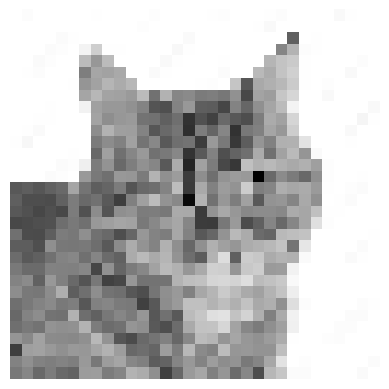

In [3]:
#dirname = os.path.dirname(__file__)
#filename = os.path.join(dirname, 'relative/path/to/file/you/want')

img = cv.imread('cat_example.jpg')   # load image file

if img is None:
    sys.exit('Could not find image')
shape_original = img.shape  # dimensions of the original image
dim_long = max(shape_original[0],shape_original[1]) # longest dimension of the original image
dim_desired_max = 32    # constrain the longest dimension for easier processing
ratio = dim_desired_max/dim_long    # scaling ratio of original image
img_resized = cv.resize(img,None,fx=ratio,fy=ratio) # scale original image using ratio

img_color = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # transform the image from BGR to RGB
img_color_resized = cv.cvtColor(img_resized, cv.COLOR_BGR2RGB)  # resize the RGB image
img_gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)  # convert the resized image to grayscale [0-255]

shape = img_gray.shape  # dimensions of the resized grayscale image

img_flat = img_gray.flatten()   # flatten the image into 1 vector for neural processing
flat_size = len(img_flat)   # length of the flattened image vector

plt.figure()
plt.imshow(img_gray,cmap='gray')
plt.axis('off')

## Making the SNS Toolbox Model


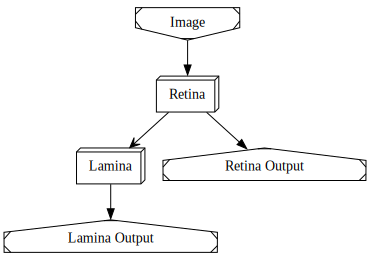

In [4]:
# General network
R = 20.0    # range of network activity (mV)
neuron_type = NonSpikingNeuron()    # generic neuron type
net = Network(name='Visual Network')    # create an empty network

# Retina
net.add_population(neuron_type,shape,name='Retina') # add a 2d population the same size as the scaled image
net.add_input('Retina', size=flat_size,name='Image')    # add a vector input for the flattened scaled image
net.add_output('Retina',name='Retina Output')  # add a vector output from the retina, scaled correctly

# Lamina
net.add_population(neuron_type,shape,name='Lamina')

del_e_ex = 160.0    # excitatory reversal potential
del_e_in = -80.0    # inhibitory reversal potential
k_ex = 1.0  # excitatory gain
k_in = -1.0/9.0 # inhibitory gain
g_max_ex = (k_ex*R)/(del_e_ex-k_ex*R)   # calculate excitatory conductance
g_max_in = (k_in*R)/(del_e_in-k_in*R)   # calculate inhibitory conductance

g_max_kernel = np.array([[g_max_in, g_max_in, g_max_in],    # kernel matrix of synaptic conductances
                         [g_max_in, g_max_ex, g_max_in],
                         [g_max_in, g_max_in, g_max_in]])
del_e_kernel = np.array([[del_e_in, del_e_in, del_e_in],    # kernel matrix of synaptic reversal potentials
                         [del_e_in, del_e_ex, del_e_in],
                         [del_e_in, del_e_in, del_e_in]])
e_lo_kernel = np.zeros([3,3])
e_hi_kernel = np.zeros([3,3]) + R
connection_hpf = NonSpikingPatternConnection(g_max_kernel,del_e_kernel,e_lo_kernel,e_hi_kernel) # pattern connection (acts as high pass filter)
net.add_connection(connection_hpf,'Retina','Lamina',name='HPF') # connect the retina to the lamina
net.add_output('Lamina',name='Lamina Output')  # add a vector output from the lamina

img_flat = img_flat*R/255.0 # scale all the intensities from 0-255 to 0-R
render(net)

In [5]:
comp = net.compile(dt=5,backend='torch')

In [6]:
# New ConductanceNetwork Construction
dt = comp.dt #torch.ones(shape[0], dtype=torch.float)
C_mem = comp.c_m #torch.rand(shape[0], dtype=torch.float)
G_mem = comp.g_m #torch.rand(shape[0], dtype=torch.float)
b_mem = comp.i_b #torch.rand(shape[0], dtype=torch.float)
Esyn = comp.del_e #torch.randn(shape, dtype=torch.float)
network_shape = [1024,1024]
# Retina layer
retina_dt = 5.0 * torch.ones(network_shape[0], dtype=torch.float)
retina_C_mem = 5.0 * torch.ones(network_shape[0], dtype=torch.float)
retina_G_mem = torch.ones(network_shape[0], dtype=torch.float)
retina_b_mem = torch.zeros(network_shape[0], dtype=torch.float)
retina_Esyn = torch.zeros(network_shape, dtype=torch.float)
retina_Gsyn = lambda x: torch.zeros_like(x, dtype=torch.float)
retina_layer = ConductanceLayerMulti(n_prev=flat_size, n=flat_size,
                                     dt=retina_dt, C_mem=retina_C_mem,
                                     G_mem=retina_G_mem, b_mem=retina_b_mem,
                                     Esyn_self=retina_Esyn, Gsyn_self=retina_Gsyn, is_first=True)

layer_Esyn = torch.tensor(sns_toolbox.networks.__kernel_connections_2d__(shape,del_e_kernel,fill_value=0.0))
layer_Gsyn = GsynModule(shape,activation_fn=lambda x: torch.clamp(x, min=0, max=1),
                        G_max=torch.ones(network_shape)*R,
                        G_min=torch.zeros(network_shape),
                        G_scale=torch.tensor(sns_toolbox.networks.__kernel_connections_2d__(shape,g_max_kernel,fill_value=0.0))
)

# Lamina layer
lamina_dt = 5.0 * torch.ones(network_shape[0], dtype=torch.float)
lamina_C_mem = 5.0 * torch.ones(network_shape[0], dtype=torch.float)
lamina_G_mem = torch.ones(network_shape[0], dtype=torch.float)
lamina_b_mem = torch.zeros(network_shape[0], dtype=torch.float)
lamina_Esyn = torch.zeros(network_shape, dtype=torch.float)
lamina_Gsyn = lambda x: torch.zeros_like(x, dtype=torch.float)
lamina_layer = ConductanceLayerMulti(n_prev=flat_size, n=flat_size,
                                     dt=lamina_dt, C_mem=lamina_C_mem,
                                     G_mem=lamina_G_mem, b_mem=lamina_b_mem,
                                     Esyn_self=lamina_Esyn, Gsyn_self=lamina_Gsyn,
                                     Esyn_prev=layer_Esyn, Gsyn_prev=layer_Gsyn)


# Construct the ConductanceNetwork
layers = [retina_layer, lamina_layer]
network = ConductanceNetwork(layers)

In [10]:
will_state = comp(torch.tensor(img_flat,dtype=torch.float))
ben_state = network(torch.tensor(img_flat,dtype=torch.float))
will_state = will_state.detach().numpy()[1024:]
ben_state = ben_state.detach().numpy()
#
assert np.allclose(will_state, ben_state, atol=1e-3), "Network states do not match" #uhoh

AssertionError: Network states do not match

In [8]:
img_shape = (32,32)
t_max = 15
steps = int(t_max/dt)
print(steps)

3


1 / 3 steps
2 / 3 steps
3 / 3 steps


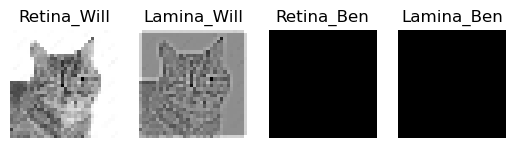

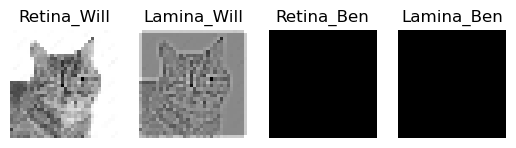

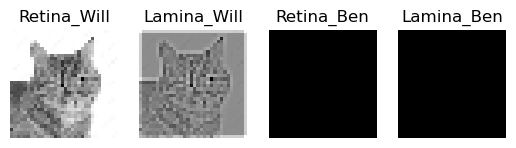

In [9]:


for i in range(steps):
    print('%i / %i steps'%(i+1,steps))
    plt.figure()    # create a figure for live plotting the retina and lamina states
    plt.subplot(1,4,1)
    plt.title('Retina_Will')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.title('Lamina_Will')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.title('Retina_Ben')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.title('Lamina_Ben')
    plt.axis('off')
    
    
    will_out = comp(torch.tensor(img_flat,dtype=torch.float))   # run the network for one dt
    will_retina = out[:flat_size].detach().numpy()    # separate the retina and lamina states
    will_lamina = out[flat_size:].detach().numpy()
    will_retina_reshape = np.reshape(retina,img_shape)   # reshape to from flat to an image
    will_lamina_reshape = np.reshape(lamina,img_shape)
    plt.subplot(1,4,1)  # plot the current state
    plt.imshow(will_retina_reshape,cmap='gray')
    plt.subplot(1, 4, 2)
    plt.imshow(will_lamina_reshape, cmap='gray')
    comp = net.compile(dt=5,backend='torch')comp = netcomp = net.compile(dt=5,backend='torch')comp = net.compile(dt=5,backend='torch')comp = net.compile(dt=5,backend='torch')comp = net.compile(dt=5,backend='torch')comp = net.compile(dt=5,backend='torch')comp = net.compile(dt=5,backend='torch')comp = net.compile(dt=5,backend='torch')comp = net.compile(dt=5,backend='torch')comp = net.compile(dt=5,backend='torch')comp = net.compile(dt=5,backend='torch').compile(dt=5,backend='torch')
    comp = net.compile(dt=5,backend='torch')comp = netnetnetnetnetnetnetnetnetnetnetnetnetnetnetnetnetnetnetnet.compile(dt=5,backend='torch')
    ben_out = network(torch.tensor(img_flat,dtype=torch.float))   # run the network for one dt
    ben_retina = network.current_states[0].detach().numpy()  # separate the retina and lamina states
    ben_lamina = out.detach().numpy()netnetnetnetnetnenetnetnetnetnetnetnetnettnetnetnetnetnetnetnetnenetnetnetnetnetnetnetnettnetnetnenetnetnetnetnetnenetnetnetnetnetnetnetnettnetnetnetnetnetnetnetnenetnetnetnetnetnetnetnettnetnetnetnetnetnetnetnenetnetnetnetnetnetnetnettnetnetnetnetnetnetnetnenetnetnetnetnetnetnetnettnetnetnetnetnetnetnetnenetnetnetnetnetnetnetnettnetnetnetnetnetnetnetnenetnetnetnetnetnetnetnettnetnetnetnetnetnetnetnenetnetnetnetnetnetnetnettnetnettnetnetnetnetnenetnetnetnetnetnetnetnettnetnet
    ben_retina_reshape = np.reshape(retina,img_shape)   # reshape to from flat to an imagenetnetnetnetnetnenetnetnetnetnetnetnetnettnetnet
    ben_lamina_reshape = np.reshape(lamina,img_shape)
    plt.subplot(1,4,3)  # plot the current state
    plt.imshow(retina_reshape,cmap='gray')
    plt.subplot(1, 4, 4)
    plt.imshow(lamina_reshape, cmap='gray')